#3D Location Estimation (LocNet)

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [3]:
def norm(data):
    height= 375
    width = 1242
    
    data.loc[:,'xmin'] = data['xmin'] / width 
    data.loc[:,'xmax'] = data['xmax'] / width
    data.loc[:,'ymax'],data.loc[:,'ymin']  = (height - data['ymin']) / height , (height - data['ymax']) / height
    
    return data

In [4]:

import pandas as pd
import numpy as np
import time

# import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tqdm.keras import TqdmCallback



# ----------- import data and scaling ----------- #
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

X_train = df_train[['ymin','xmin','ymax', 'xmax']]
y_train = df_train[['xloc','zloc']].values

X_test = df_test[['ymin','xmin','ymax', 'xmax']]
y_test = df_test[['xloc','zloc']].values


X_train = norm(X_train).values
X_test = norm(X_test).values

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
print(X_train[:10])

In [18]:
# TRAINING MODE


# ----------- create model ----------- #
model = keras.Sequential()
model.add(Dense(100, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(2, kernel_initializer='normal'))


# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
model.compile(loss='mse',optimizer='adam',metrics=['mae', 'mse'])

# ----------- define callbacks ----------- #
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                verbose=1, min_delta=1e-4, mode='min')
modelname = "model@{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(modelname))

# ----------- start training ----------- #
history = model.fit(X_train, y_train,
            validation_split=0.2, epochs=20, batch_size=1024,verbose=0, callbacks=[tensorboard, TqdmCallback(verbose=1)])


# ----------- save model and weights ----------- #
model_json = model.to_json()
with open("generated_files/{}.json".format(modelname), "w") as json_file:
   json_file.write(model_json)

model.save_weights("generated_files/{}.h5".format(modelname))
print("Saved model to disk")



Saved model to disk


In [11]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-t_rhxk5s
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-t_rhxk5s
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dcf6d428a23727780cedcb671ebd9791b1b6f106_-py3-none-any.whl size=126395 sha256=3736f47c72c72e9f5987dab8d871c683a71a897e4e13c32b27f07d343afb98f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-48f4ajwo/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
  Attempting uninstall: tensorflow-docs
    Found existing installation: tensorflow-docs 0.0.000af8a0cc1fe850249fe567b75a976718f64bef8-
    Uninstalling tensorflow-docs-0.0.000af8a0cc1fe850249fe567b75a976718f64bef8-:
      Successfully uninstalled tensorflow-docs-0.0.000af8a0cc1fe850249fe567b75a976718f64bef8-
Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,149.119431,9.103161,149.119431,140.867691,8.950023,140.867691,5
6,135.756393,8.733881,135.756393,125.497818,8.454881,125.497818,6
7,118.688164,8.127542,118.688164,107.274651,7.648701,107.274651,7
8,101.118156,7.358366,101.118156,91.415131,7.060782,91.415131,8
9,87.367493,6.825920,87.367493,79.290237,6.607408,79.290237,9


In [14]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


Text(0, 0.5, 'Mean Average Error')

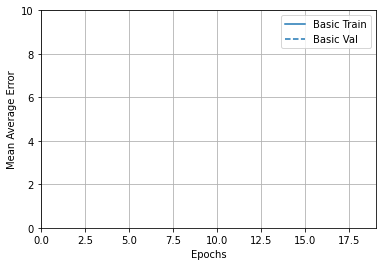

In [19]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 10])
plt.ylabel('Mean Average Error')



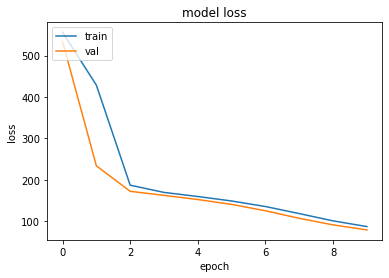

In [17]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [20]:
# INFERENCE MODE

from tensorflow.keras.models import model_from_json

df_test = pd.read_csv('data/test.csv')
X_test = df_test[['ymin', 'xmin', 'ymax','xmax']]
y_test = df_test[['xloc' ,'zloc']].values

    
X_test = norm(X_test).values


MODEL = "model@1597671595"
WEIGHTS = "model@1597671595"

# load json and create model
json_file = open('generated_files/{}.json'.format(MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights("generated_files/{}.h5".format(WEIGHTS))
print("Loaded model from disk")

# loaded_model = model
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test)


# save predictions
df_result = df_test
df_result['zloc_pred'] = -100000
df_result['xloc_pred'] = -100000


for idx, row in df_result.iterrows():
    df_result.at[idx, 'zloc_pred'] = y_pred[idx][2]
    df_result.at[idx, 'xloc_pred'] = y_pred[idx][0]

df_result.to_csv('data/predictions_new.csv', index=False)
print("Saved predictions to file")

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Loaded model from disk
